# Figure 6 — Serial dependence for variable set size

In [89]:
include("src/model.jl")
include("src/serialdep.jl")
include("src/fig_serialdep.jl");

In [2]:
win  = π/4
step = π/30

smooth_serialdep(df) = smooth_serialdep_error(
    df; 
    distcol=:abs_dist,
    errcol=:folded_error,
    win=win,
    step=step,
);

## 1. Data (Panichello 2019, Exp 1)

### 1.1. Load data

In [3]:
using MATLAB, DataFramesMeta

In [4]:
df_exp = DataFrame()

for subject in 1:90
    data = read_matfile("../data/Panichello19/exp1a_humans_subjects/sub$(subject).mat")
    jval = jvalue(data["d"])
    
    df_data = DataFrame(Dict(k => vec(v) for (k,v) in jval))
    
    # get relevant cols
    stimuli = df_data.target
    reports = df_data.response
    
    # there are 360 possible cues
    cues = round.(Int, stimuli ./ (2π/360))
        
    # transform angles to (-π, π) range
    stimuli = cdist.(0, stimuli)
    reports = cdist.(0, reports)

    # get df
    df = get_df_consecutive(cues, stimuli, reports)
    df.subject  = fill(subject, nrow(df))
    
    df.K  = df_data.K[2:end]
    df.RI = df_data.RI[2:end]
    
    # compute distances and errors
    compute_dist_error!(df)
    
    append!(df_exp, df)
end

filter!(:abs_error => <(π/4), df_exp);

In [5]:
df_exp_K1 = @subset(df_exp, :K .== 1)
df_exp_K3 = @subset(df_exp, :K .== 3);

In [6]:
exp_x, serialdep_exp_all, serialdep_exp_all_e = smooth_serialdep(df_exp)
exp_x, serialdep_exp_K1,  serialdep_exp_K1_e  = smooth_serialdep(df_exp_K1)
exp_x, serialdep_exp_K3,  serialdep_exp_K3_e  = smooth_serialdep(df_exp_K3);

### 1.2 Test if serial dependence is stronger for K = 3 than K = 1

In [7]:
using HypothesisTests, Bootstrap

In [8]:
function bootstrap_dog(df; niter=1000, xcol=:abs_dist, ycol=:folded_error)
    data = collect(zip(df[:,xcol], df[:,ycol]))
    
    fun(sample) = begin
        x = map(first, sample)
        y = map(last, sample)
        params, serialdep = fit_dog(x, y)
        return serialdep
    end
    
    return bootstrap(fun, data, BasicSampling(niter))
end;

In [14]:
function permute_dog_2(dfcombined, len1; niter=1000, xcol=:abs_dist, ycol=:folded_error)    
    @assert len1 < nrow(dfcombined)
    
    serialdeps = zeros(niter, 2)
    
    x = dfcombined[:,xcol]
    y = dfcombined[:,ycol]
    
    for i in 1:niter
        index = shuffle(1:nrow(dfcombined))
        
        # fit dog for 1st population
        p, s = fit_dog(x[index[1:len1]], y[index[1:len1]])
        serialdeps[i,1] = s
        
        # fit dog for 2nd population
        p, s = fit_dog(x[index[len1+1:end]], y[index[len1+1:end]])
        serialdeps[i,2] = s
    end
    
    return serialdeps
end;

In [15]:
perm_K = permute_dog_2(df_exp, nrow(df_exp_K1); niter=20_000);

In [16]:
# group permutation test
actual_dep_K1 = (@df df_exp_K1 fit_dog(:abs_dist, :folded_error))[2]
actual_dep_K3 = (@df df_exp_K3 fit_dog(:abs_dist, :folded_error))[2]
actual_diff = actual_dep_K3 - actual_dep_K1;

In [21]:
# p-value
mean(perm_K[:,2] .- perm_K[:,1] .≥ actual_diff)

0.032

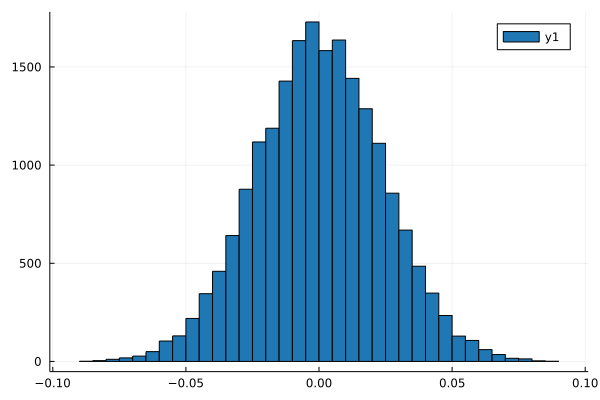

In [18]:
histogram(perm_K[:,2] .- perm_K[:,1])

In [373]:
straps_K1 = straps(bootstrap_dog(df_exp_K1))[1]
straps_K3 = straps(bootstrap_dog(df_exp_K3))[1];

In [374]:
EqualVarianceTTest(straps_K1, straps_K3)

Two sample t-test (equal variance)
----------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -0.04047
    95% confidence interval: (-0.04189, -0.03905)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   [1000,1000]
    t-statistic:              -55.74006371353387
    degrees of freedom:       1998
    empirical standard error: 0.0007260487850777307


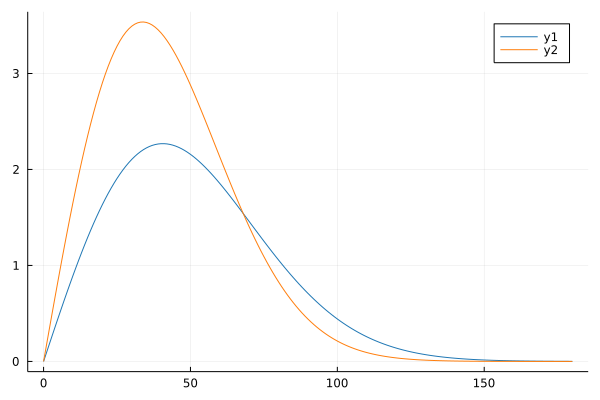

In [423]:
fig = plot()

@chain df_exp_K1 begin
    @aside params, serialdep = @df _ fit_dog(:abs_dist, :folded_error)
    @orderby :abs_dist
    @df plot!(rad2deg.(:abs_dist), rad2deg.(dog(:abs_dist, params)))
end

@chain df_exp_K3 begin
    @aside params, serialdep = @df _ fit_dog(:abs_dist, :folded_error)
    @orderby :abs_dist
    @df plot!(rad2deg.(:abs_dist), rad2deg.(dog(:abs_dist, params)))
end

In [376]:
issig = zeros(length(x))
for s in 1:length(x)
    issig[s] = bootstrapsig(serialdep_exp_K3[s,:], serialdep_exp_K1[s,:])
end

## 2. Simulation

In [9]:
using FileIO
df_sim = load("data/fig6.jld2", "df_sim")
filter!(:abs_error => <(π/4), df_sim);

In [ ]:
nsubjects = 11
nrepeats = 3 # 1
naug = 1000

# main df
df_sim = DataFrame()

# different set sizes
Ks = [1,3]
timing = TimingCondition("", 1000, 1500)

for subject in 1:nsubjects
    lg("$subject / $nsubjects")
    
    for K in Ks
        lg(K)
        
        # get simulation 
        sim = Simulation(1000, 32, K; seed=SEEDS[subject])

        # get sequence
        seq = getseq(sim, timing, rand(1:sim.nstimuli); repeat=nrepeats)

        # run simulation
        _, _, rs = run!(sim, seq)
        
        # only keep cue and rs for timepoints after ri
        cues = map(s -> s[1], seq[1:2:end])
        rs   = rs[1:2:end,:,1]
        
        # get df with reports
        df = get_df_consecutive(sim, cues, rs; naug=naug)
        df.subject = fill(subject, nrow(df))
        df.K       = fill(K,       nrow(df))
        
        compute_dist_error!(df)
        
        # append to big df
        append!(df_sim, df)
        
    end
end

filter!(:abs_error => <(π/4), df_sim);

In [ ]:
#using FileIO
#save("data/fig7.jld2", "df_sim", df_sim)

In [10]:
df_sim_K1 = @subset(df_sim, :K .== 1)
df_sim_K3 = @subset(df_sim, :K .== 3);

In [11]:
sim_x, serialdep_sim_all, serialdep_sim_all_e = smooth_serialdep(df_sim)
sim_x, serialdep_sim_K1,  serialdep_sim_K1_e  = smooth_serialdep(df_sim_K1)
sim_x, serialdep_sim_K3,  serialdep_sim_K3_e  = smooth_serialdep(df_sim_K3);

## 3. Final figure

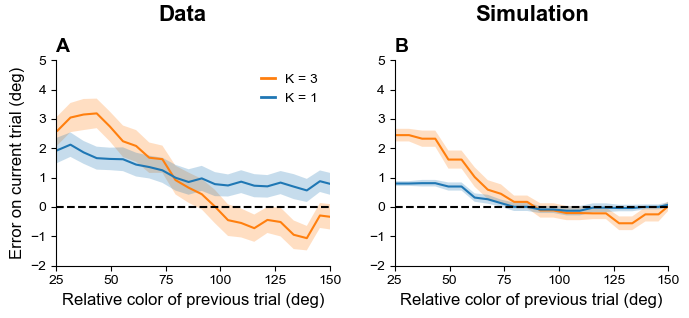

In [90]:
fig = figure("fig6_serialdep_setsize", figsize=(7, 3))

# A: RI
ax = subplot(121)
plt.title("A")

plot_serialdep_error!(ax, exp_x, serialdep_exp_K3; color=get_palette(2), label="K = 3")
plot_serialdep_error!(ax, exp_x, serialdep_exp_K1; color=get_palette(1), label="K = 1")
ax.axhline(y = 0, color = "k", linestyle = "--")
ax.set_xlim(25, 150)
ax.set_ylim(-2, 5)
legend() |> legend_shorten_lines!

# B: ITI
ax = subplot(122)
plt.title("B")

plot_serialdep_error!(ax, sim_x, serialdep_sim_K3; color=get_palette(2), label="K = 3")
plot_serialdep_error!(ax, sim_x, serialdep_sim_K1; color=get_palette(1), label="K = 1")
ax.axhline(y = 0, color = "k", linestyle = "--")

ax.set_ylabel("")

ax.set_xlim(25, 150)
ax.set_ylim(-2, 5)

# Update the figure
fig.tight_layout(w_pad=2, h_pad=2, rect=(0.0, 0.0, 1.0, 1.0)) # (left, bottom, right, top)

# add Data and Simulation annotations
annotate_data_simulation_top!();

In [92]:
fig.savefig("figs/fig6_serialdep_setsize.pdf", bbox_inches="tight");